In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import LSTM, RepeatVector,TimeDistributed, Dense, Input

2024-03-24 11:11:35.224044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:11:35.265614: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 11:11:35.267039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 11:11:35.993903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


            Robberies
Month                
1966-01-01         41
1966-02-01         39
1966-03-01         50
1966-04-01         40
1966-05-01         43


<Axes: xlabel='Month'>

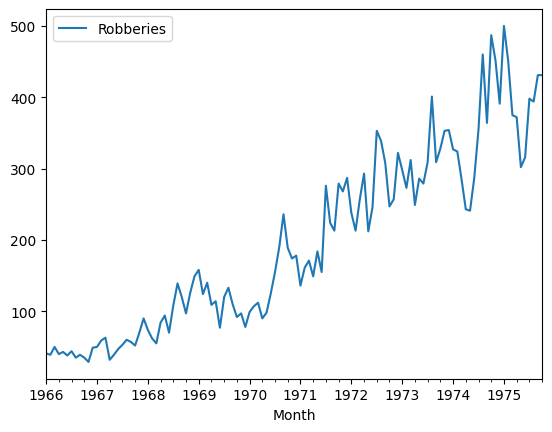

In [2]:

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-robberies.csv")
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month")
print(df.head())
df.plot()

In [3]:
max_value = max(df['Robberies'])
min_value = min(df['Robberies'])

def normalize_data(data):
    return (data - min_value) / (max_value - min_value)

def denormalize_data(data):
    return data * (max_value - min_value) + min_value

normalized_df = normalize_data(df['Robberies'])

n_features = 1
n_future = 20
n_past = 40

x = []
for i in range(len(normalized_df) - n_past - 1):
    window = normalized_df.iloc[i:i+n_past].to_numpy().reshape(-1, 1)
    x.append(window)
x = np.array(x)

y = []
for i in range(n_past, len(normalized_df)-n_future+1):
    window = normalized_df.iloc[i:i+n_future].to_numpy().reshape(-1, 1)
    y.append(window)
y = np.array(y)

train_size = 0.8
validation_size = 0.1
test_size = 0.1

indices = np.arange(min(len(x),len(y)))
train_index = int(train_size * len(indices))
val_index = int((train_size + validation_size) * len(indices))

train_indices = indices[:train_index]
val_indices = indices[train_index:val_index]
test_indices = indices[val_index:]

x_train, y_train = x[train_indices], y[train_indices]
x_val, y_val = x[val_indices], y[val_indices]
x_test, y_test = x[test_indices], y[test_indices]

print("Number of samples in training set:", len(x_train))
print("Number of samples in validation set:", len(x_val))
print("Number of samples in test set:", len(x_test))

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Number of samples in training set: 47
Number of samples in validation set: 6
Number of samples in test set: 6
(47, 40, 1)
(6, 40, 1)
(6, 40, 1)
(47, 20, 1)
(6, 20, 1)
(6, 20, 1)


In [ ]:
batch_size = x_train.shape[0]
epochs = 1000
hidden_layer = 4000

model = Sequential()
model.add(LSTM(hidden_layer, input_shape=(n_past, n_features)))
model.add(RepeatVector(n_future))
model.add(LSTM(hidden_layer, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

2024-03-24 11:11:45.282964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4000)              64032000  
                                                                 
 repeat_vector (RepeatVecto  (None, 20, 4000)          0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 20, 4000)          128016000 
                                                                 
 time_distributed (TimeDist  (None, 20, 1)             4001      
 ributed)                                                        
                                                                 
Total params: 192052001 (732.62 MB)
Trainable params: 192052001 (732.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10

1/1 [==============================] - 1s 1s/step
MAPE: 20.27293991276285
RMSE: 89.0447628063595
AME: 73.2617301940918


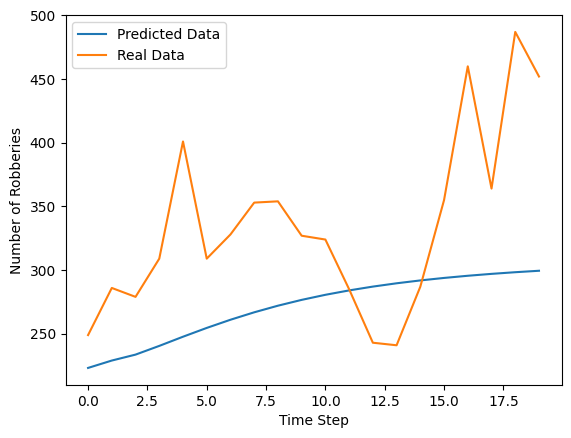

1/1 [==============================] - 1s 1s/step
MAPE: 17.538679747832315
RMSE: 79.45105611602192
AME: 64.29900970458985


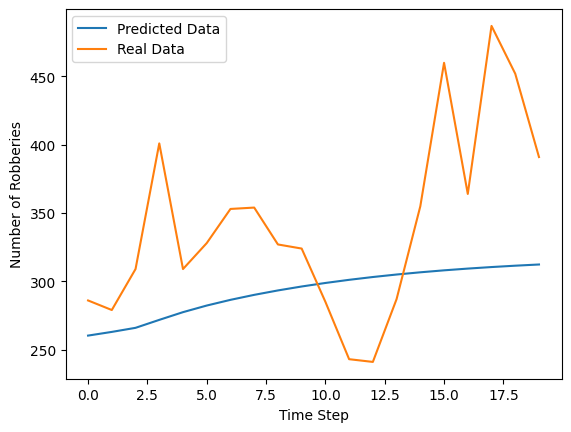

1/1 [==============================] - 1s 1s/step
MAPE: 19.015773601136885
RMSE: 89.67051555129625
AME: 72.55909881591796


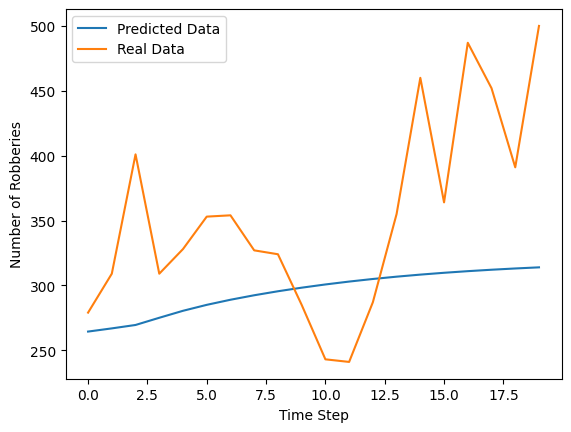

1/1 [==============================] - 1s 1s/step
MAPE: 20.679079591135316
RMSE: 96.02537621818881
AME: 80.26286926269532


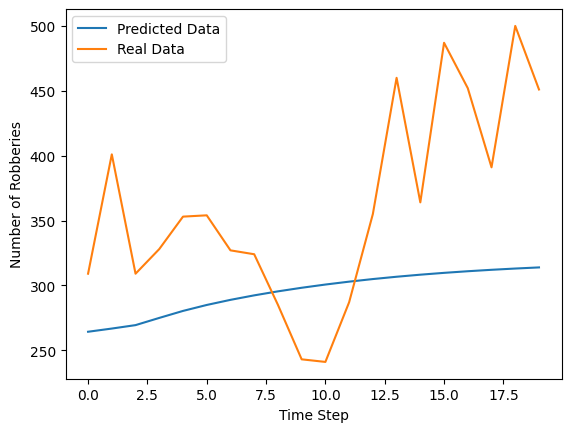

1/1 [==============================] - 1s 1s/step
MAPE: 22.605468357454445
RMSE: 104.42817919654254
AME: 88.62822265625


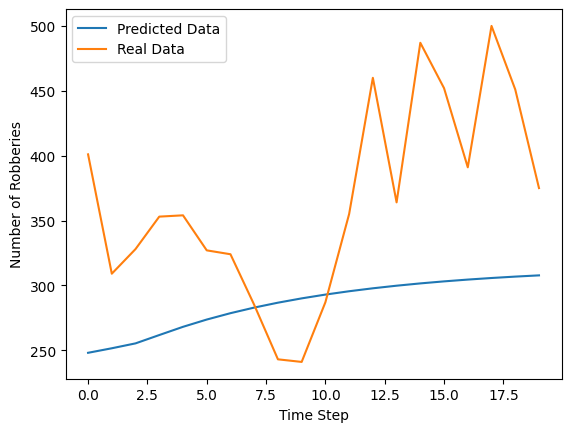

1/1 [==============================] - 1s 1s/step
MAPE: 20.614221554428987
RMSE: 95.80446089701039
AME: 80.3912139892578


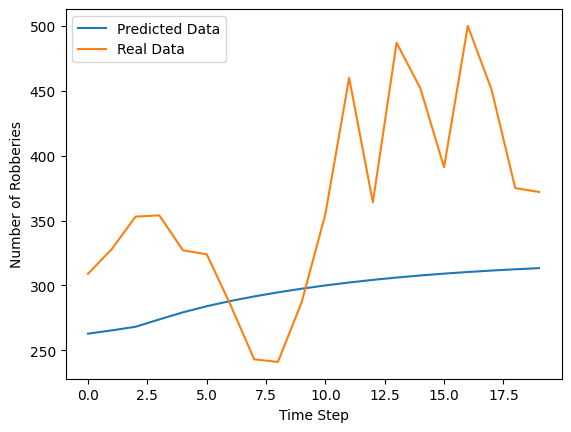

In [7]:
predictions = []
for i, x in enumerate(x_val):
    x = x.reshape(1,n_past,1)
    predicted = denormalize_data(model.predict(x)).flatten()
    predictions.append(predicted)
    real = denormalize_data(y_val[i].flatten())
    
    print(f"MAPE: {np.mean(np.abs((real - predicted) / real)) * 100}")
    print(f"RMSE: {np.sqrt(np.mean((real - predicted) ** 2))}")
    print(f"AME: {np.mean(np.abs(real - predicted))}")
    
    plt.plot(predicted, label='Predicted Data')
    plt.plot(real, label='Real Data')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Robberies')
    plt.legend()
    plt.show()

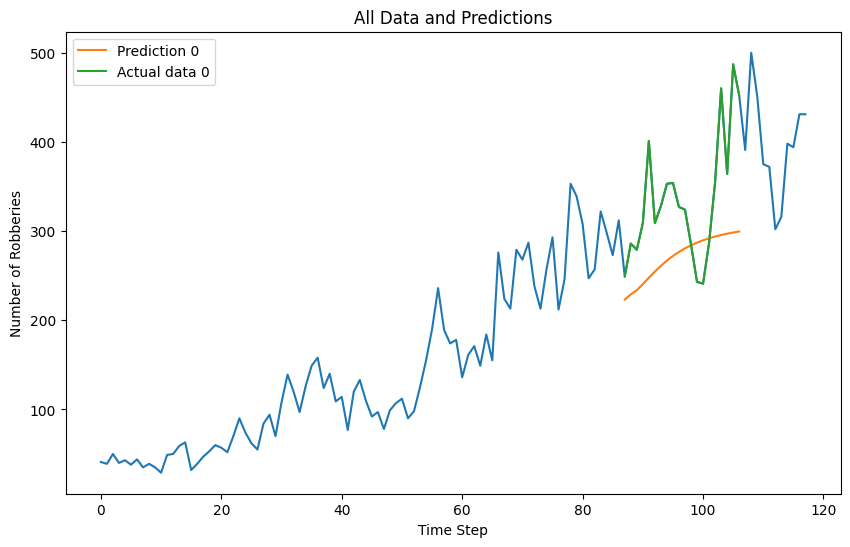

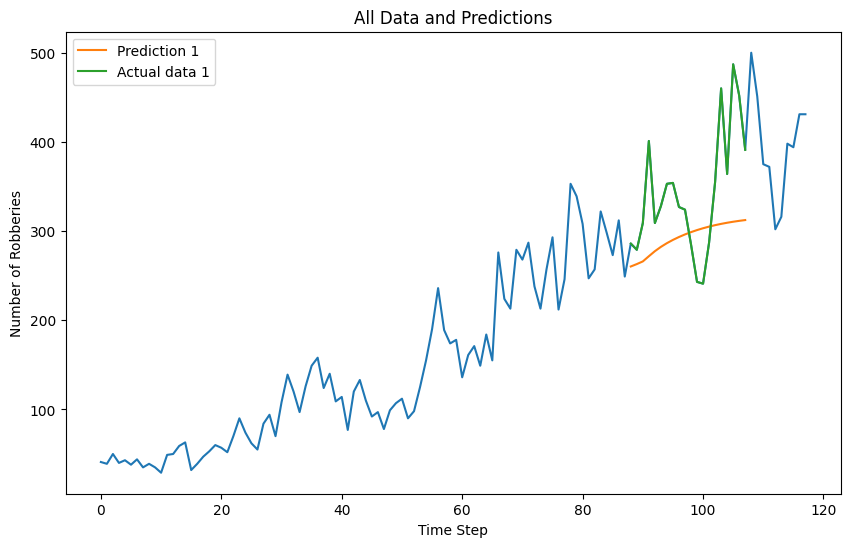

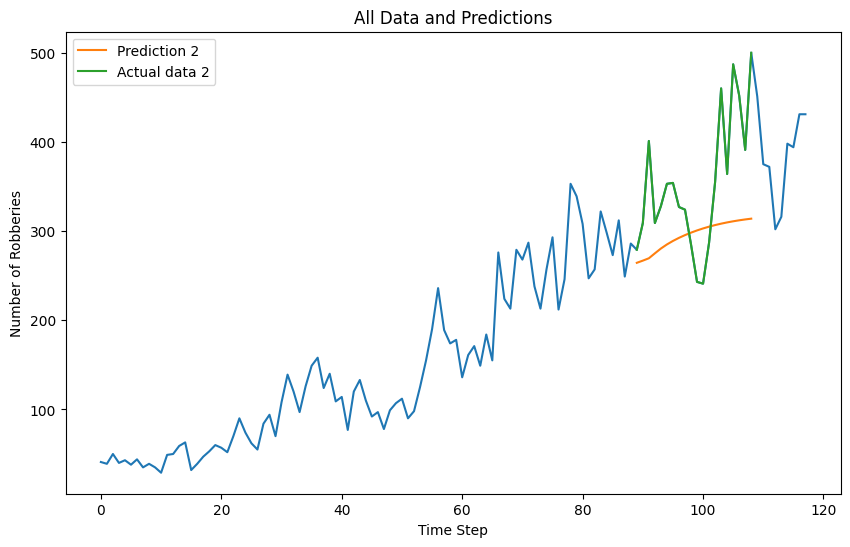

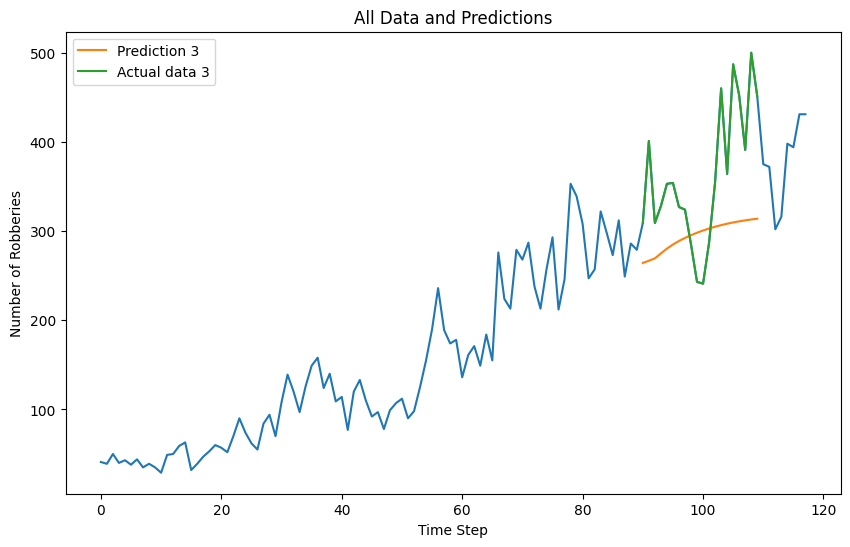

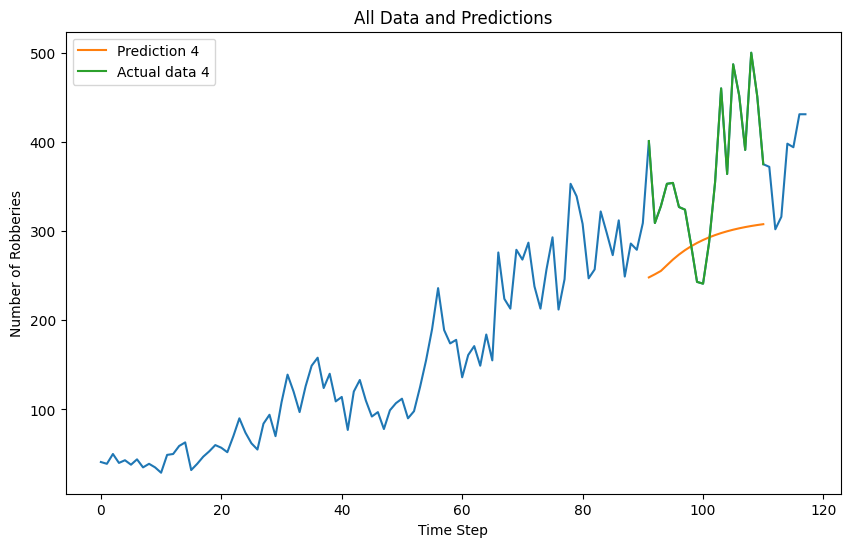

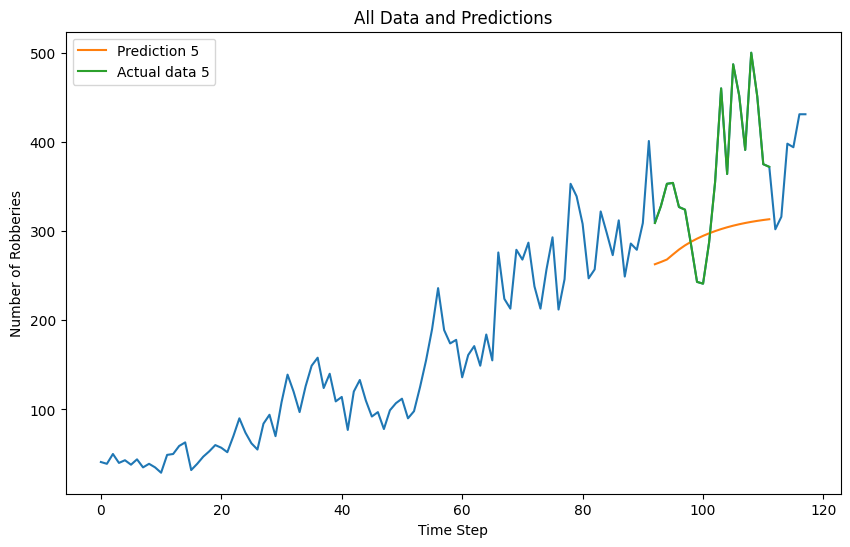

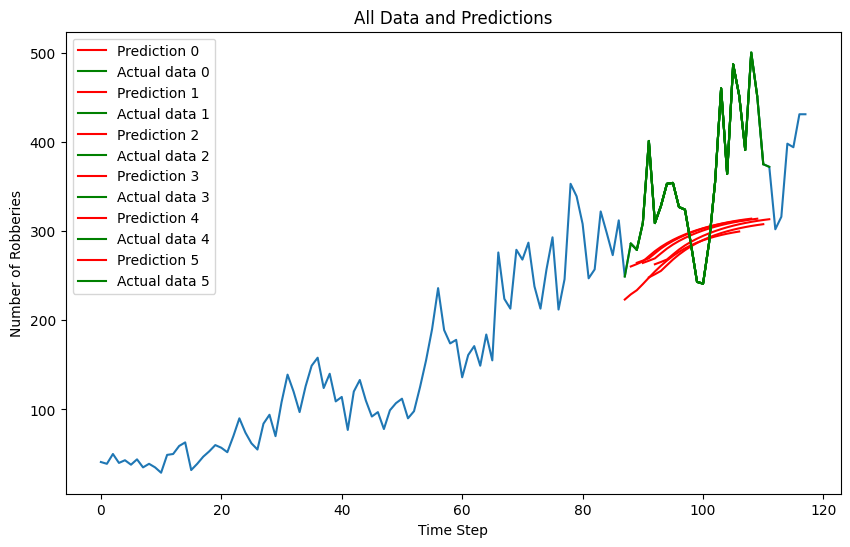

In [8]:
robberies_values = denormalize_data(normalize_data(df['Robberies'].values))
predicted_values = []

for i, p in enumerate(predictions):
    index = val_indices[i] + n_past
    x_values = [j for j in range(index,index+n_future)]
    plt.figure(figsize=(10, 6))
    plt.plot(robberies_values)
    plt.plot(x_values,p, label=f"Prediction {i}")
    plt.plot(x_values,denormalize_data(y_val[i].flatten()), label=f"Actual data {i}")
    plt.xlabel('Time Step')
    plt.ylabel('Number of Robberies')
    plt.title('All Data and Predictions')
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(robberies_values)

for i, p in enumerate(predictions):
    index = val_indices[i] + n_past
    x_values = [j for j in range(index,index+n_future)]
    plt.plot(x_values,p, label=f"Prediction {i}", color="red")
    plt.plot(x_values,denormalize_data(y_val[i].flatten()), label=f"Actual data {i}", color="green")

plt.xlabel('Time Step')
plt.ylabel('Number of Robberies')
plt.title('All Data and Predictions')
plt.legend()
plt.show()